In [44]:
import matplotlib.pyplot as plt
import process_data
import pandas as pd
import numpy as np
from get_log_time import get_log_tags_dataframe, tag_name_to_value
from process_data import get_log_files, get_log_files_dataframe, get_log_tags_dataframe, \
    clean_log_dataframe, add_query_id_node_id_dataframe, get_msg_id_to_batch_id_dict, \
    add_batch_id_to_all_compute, compute_task_times, global_search_udl_times

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
%reload_ext autoreload


need to graph all the data collected mate

In [47]:
remote_single_node_data_folder = "/home/nam/workspace/rdma_anns/remote_data/single_node/"
remote_rdma_baseline_data_folder = "/home/nam/workspace/rdma_anns/remote_data/rdma/baseline/"
remote_rdma_test_compute_pipeline_data_folder = "/home/nam/workspace/rdma_anns/remote_data/rdma/test_compute_pipeline/"
local_baseline_data_folder = "/home/nam/workspace/rdma_anns/local_data/baseline/"
local_test_compute_pipeline_data_folder = "/home/nam/workspace/rdma_anns/local_data/test_compute_pipeline/"

local duration dataframes

In [48]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [49]:
def get_dataframes_from_log_files(data_folder):
    suffix = ".dat"
    log_files = get_log_files(data_folder, suffix)
    df = get_log_files_dataframe(log_files)
    
    log_tags_df = get_log_tags_dataframe()
    tag_fn = lambda tag_name: tag_name_to_value(log_tags_df, tag_name)
    
    df = clean_log_dataframe(df)
    df, abnormal_rows = add_query_id_node_id_dataframe(df)
    
    msg_id_to_batch_id_dict = get_msg_id_to_batch_id_dict(df, tag_fn)
    # print(msg_id_to_batch_id_dict)
    conflicts = add_batch_id_to_all_compute(df, msg_id_to_batch_id_dict)
    
    roundtrip_durations, query_send_to_serialize_durations, batch_serialization_time, batch_send_latency,\
        put_and_forget_time, transfer_messages_time, prep_batch_serialize_time, batch_deserialize_time,\
        query_pushed_to_start_time, compute_query_time, compute_result_push_time, compute_result_to_serialize_time \
        = compute_task_times(df, tag_fn)
    
    search_read_df, search_step_df, global_udl_handler_time_df, global_udl_handler_bytes_df,\
        push_message_time_df = global_search_udl_times(df, tag_fn)

    return roundtrip_durations, query_send_to_serialize_durations, batch_serialization_time, batch_send_latency,\
        put_and_forget_time, transfer_messages_time, prep_batch_serialize_time, batch_deserialize_time,\
        query_pushed_to_start_time, compute_query_time, compute_result_push_time, compute_result_to_serialize_time, \
        search_read_df, search_step_df, global_udl_handler_time_df, global_udl_handler_bytes_df,\
        push_message_time_df

In [37]:
def visualize_dataframe(df, y_column_name,y_label, ax_0 ,ax_1):
    ax_0.scatter(df["timestamp"], df[y_column_name], s = 0.15, alpha = 0.1)
    ax_0.set_xlabel("start timestamp")
    ax_0.set_ylabel(y_label)
    latency = df[y_column_name].to_numpy()
    filtered_latency = latency[~is_outlier(latency)]
    ax_1.hist(filtered_latency, 50)
    ax_1.set_ylabel(y_label)

def visualize_duration_dataframe(df, ax_0, ax_1):
    visualize_dataframe(df, "latency", "us", ax_0, ax_1)

def visualize_extra_dataframe(df, y_label, ax_0, ax_1):
    visualize_dataframe(df, "extra", y_label, ax_0, ax_1)
    

now we need to graph everything in a grid, need the main suspects of the latency: 
- roundtrip durations
- batch send latency
- time for when compute query is pushed to queue to when its popped off for compute
- Time from putting a compute query/result onto the batching thread queue to it being serialized
- udl handler times



In [38]:
def graph_data_from_log_files(data_folder, png_output_path):
    roundtrip_durations, query_send_to_serialize_durations, batch_serialization_time, batch_send_latency,\
        put_and_forget_time, transfer_messages_time, prep_batch_serialize_time, batch_deserialize_time,\
        query_pushed_to_start_time, compute_query_time, compute_result_push_time, compute_result_to_serialize_time, \
        search_read_df, search_step_df, global_udl_handler_time_df, global_udl_handler_bytes_df,\
        push_message_time_df = get_dataframes_from_log_files(data_folder)
    summary_fig, axes = plt.subplots(10, 2)
    summary_fig.set_size_inches(15, 20) 
    axes[0, 0].set_title("roundtrip compute latency")
    visualize_duration_dataframe(roundtrip_durations, axes[0, 0], axes[0, 1])
    axes[1, 0].set_title("batch send latency")
    visualize_duration_dataframe(batch_send_latency, axes[1, 0], axes[1, 1])
    axes[2, 0].set_title("compute query pushed to start latency")
    visualize_duration_dataframe(query_pushed_to_start_time, axes[2, 0], axes[2, 1])
    axes[3, 0].set_title("compute query pushed to serialize latency")
    visualize_duration_dataframe(query_send_to_serialize_durations, axes[3, 0], axes[3, 1])
    axes[4, 0].set_title("compute result pushed to serialize latency")
    visualize_duration_dataframe(compute_result_to_serialize_time, axes[4, 0], axes[4, 1])
    axes[5, 0].set_title("global udl handler completion time")
    visualize_duration_dataframe(global_udl_handler_time_df, axes[5, 0], axes[5, 1])
    axes[6, 0].set_title("global udl handler number of bytes")
    visualize_extra_dataframe(global_udl_handler_bytes_df, "number of bytes in batch",axes[6, 0], axes[6, 1])
    summary_fig.tight_layout()
    summary_fig.savefig(png_output_path, dpi=300)

number of existing batch id 856443
No conflicts - all existing batch_ids match the dictionary
round trip latency of compute query
count 50379
mean:  9750.15488596439
std:  6851.964600580492
90p:   21175.250000000007
99p:  29216.97
compute query duration from send request to start of serialization of that batch on batching thread
count 50379
mean:  1535.5764256932453
std:  1784.5414656562843
90p:   3789.550000000001
99p:  8820.900000000009
batch serialization time between udls for global search
count 16001
mean:  6.142241109930629
std:  11.697349484054596
90p:   9.25
99p:  15.25
batch sending latency between udls for global search
num_malformed 1
count 16001
mean:  2144.575495281545
std:  1689.20515593784
90p:   4232.25
99p:  8714.75
time to complete a put_and_forget
count 16001
mean:  684.0076870195613
std:  813.7898929758566
90p:   1001.5
99p:  4717.5
time to transfer messages from cluster messages to to_send
count 12012
mean:  29.430361305361306
std:  55.746670597983965
90p:   40.75


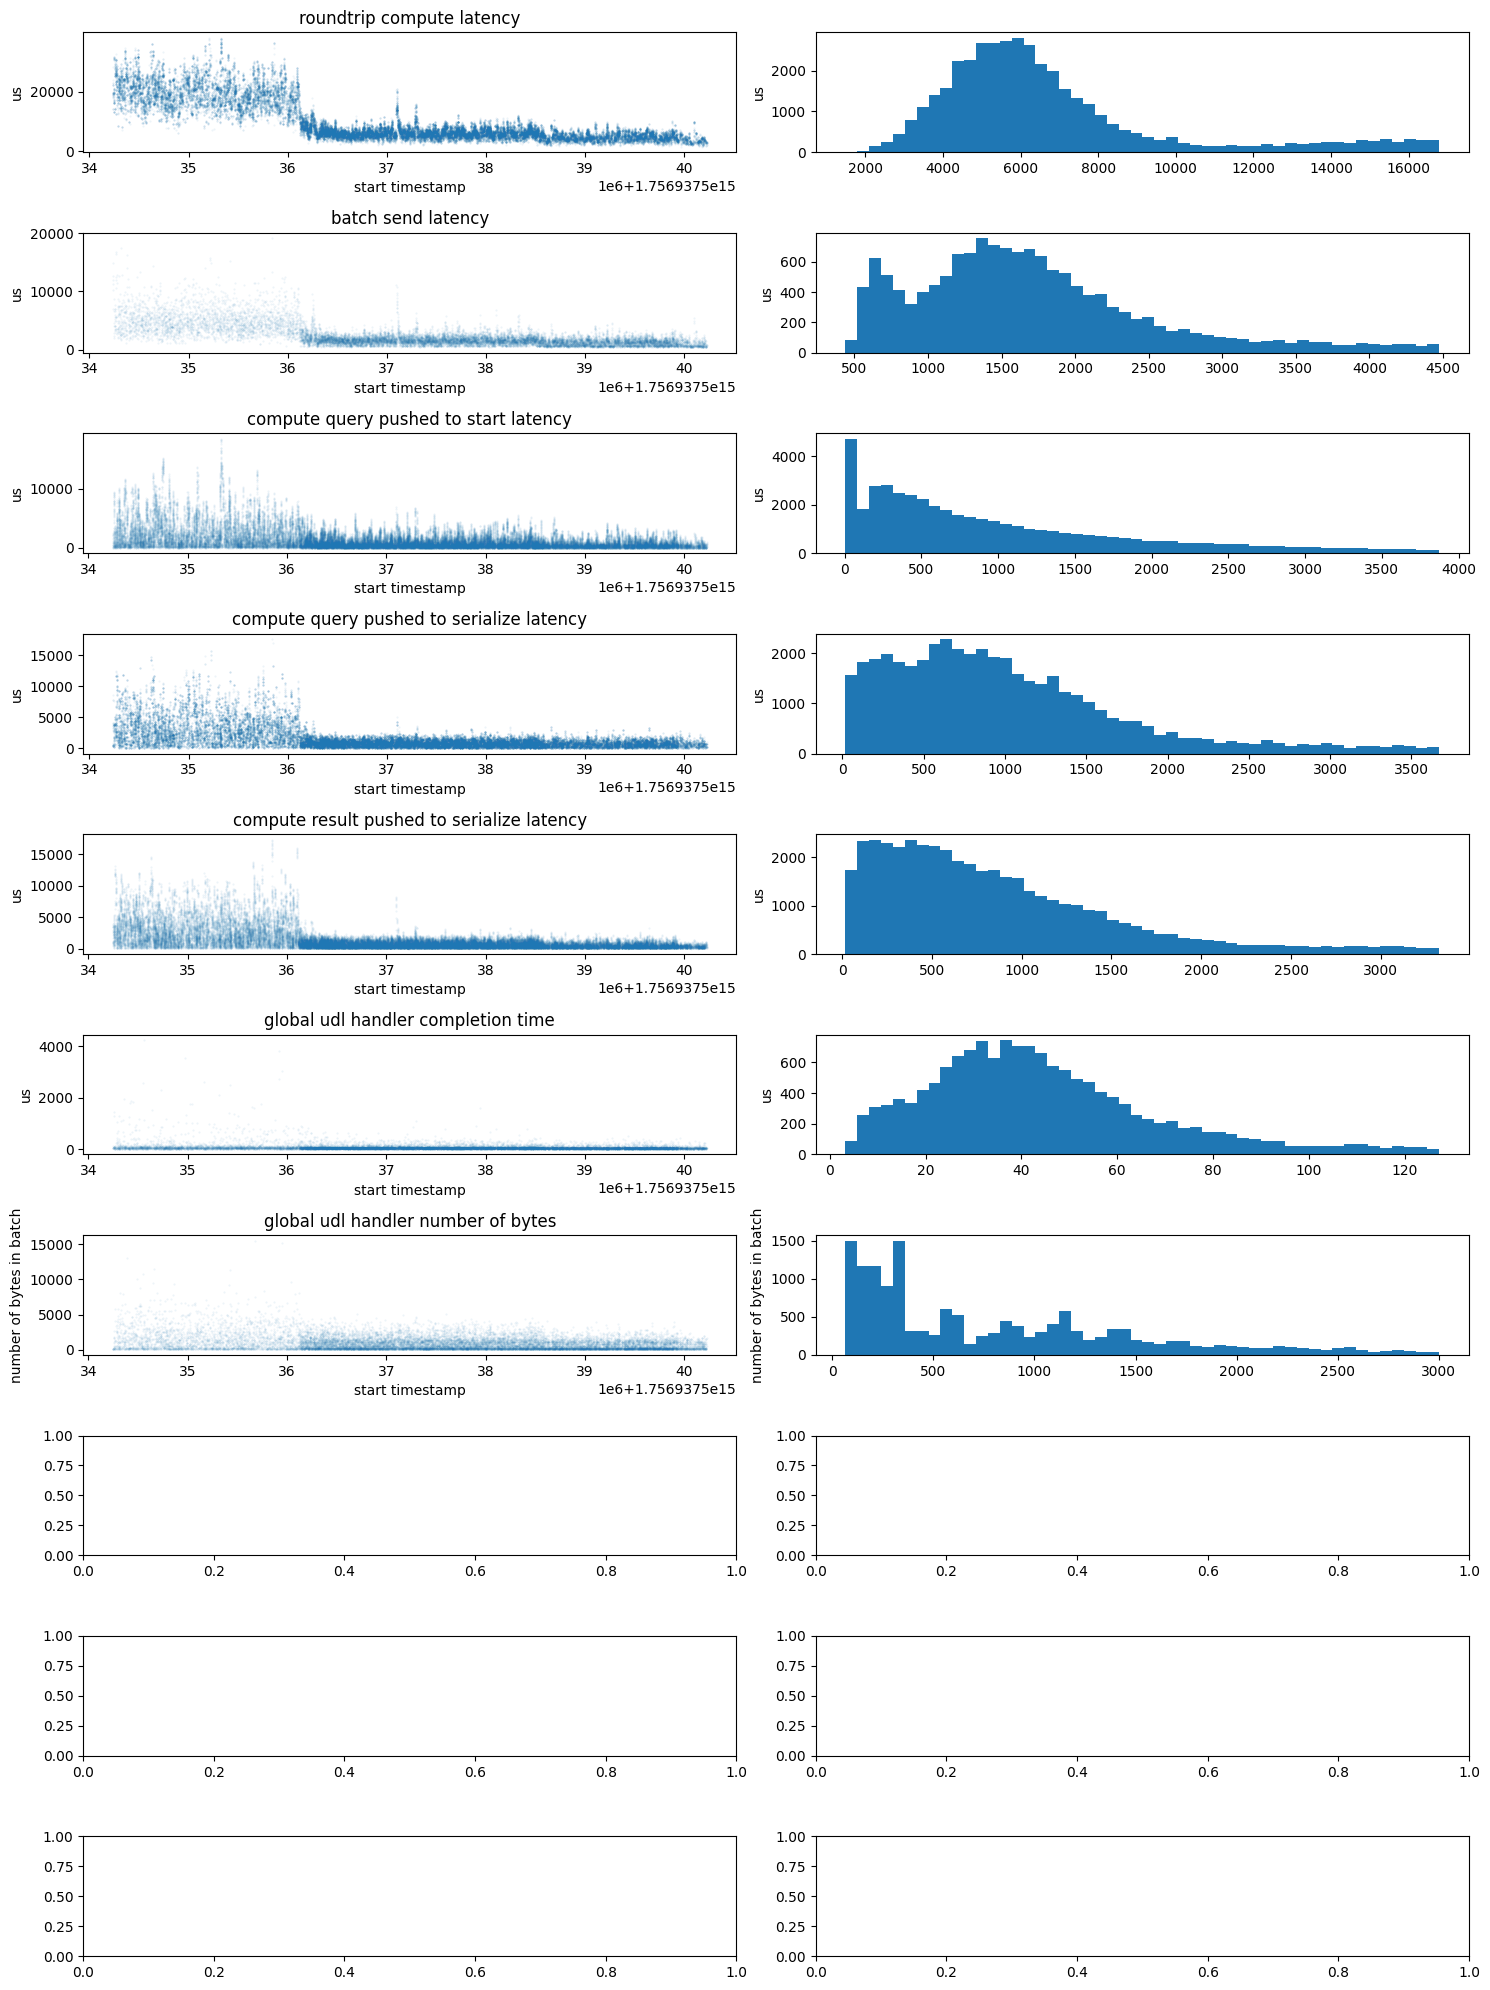

In [40]:
graph_data_from_log_files(local_baseline_data_folder, "grid_baseline.png")

number of existing batch id 856443
No conflicts - all existing batch_ids match the dictionary
round trip latency of compute query
count 50379
mean:  9750.15488596439
std:  6851.964600580492
90p:   21175.250000000007
99p:  29216.97
compute query duration from send request to start of serialization of that batch on batching thread
count 50379
mean:  1535.5764256932453
std:  1784.5414656562843
90p:   3789.550000000001
99p:  8820.900000000009
batch serialization time between udls for global search
count 16001
mean:  6.142241109930629
std:  11.697349484054596
90p:   9.25
99p:  15.25
batch sending latency between udls for global search
num_malformed 1
count 16001
mean:  2144.575495281545
std:  1689.20515593784
90p:   4232.25
99p:  8714.75
time to complete a put_and_forget
count 16001
mean:  684.0076870195613
std:  813.7898929758566
90p:   1001.5
99p:  4717.5
time to transfer messages from cluster messages to to_send
count 12012
mean:  29.430361305361306
std:  55.746670597983965
90p:   40.75


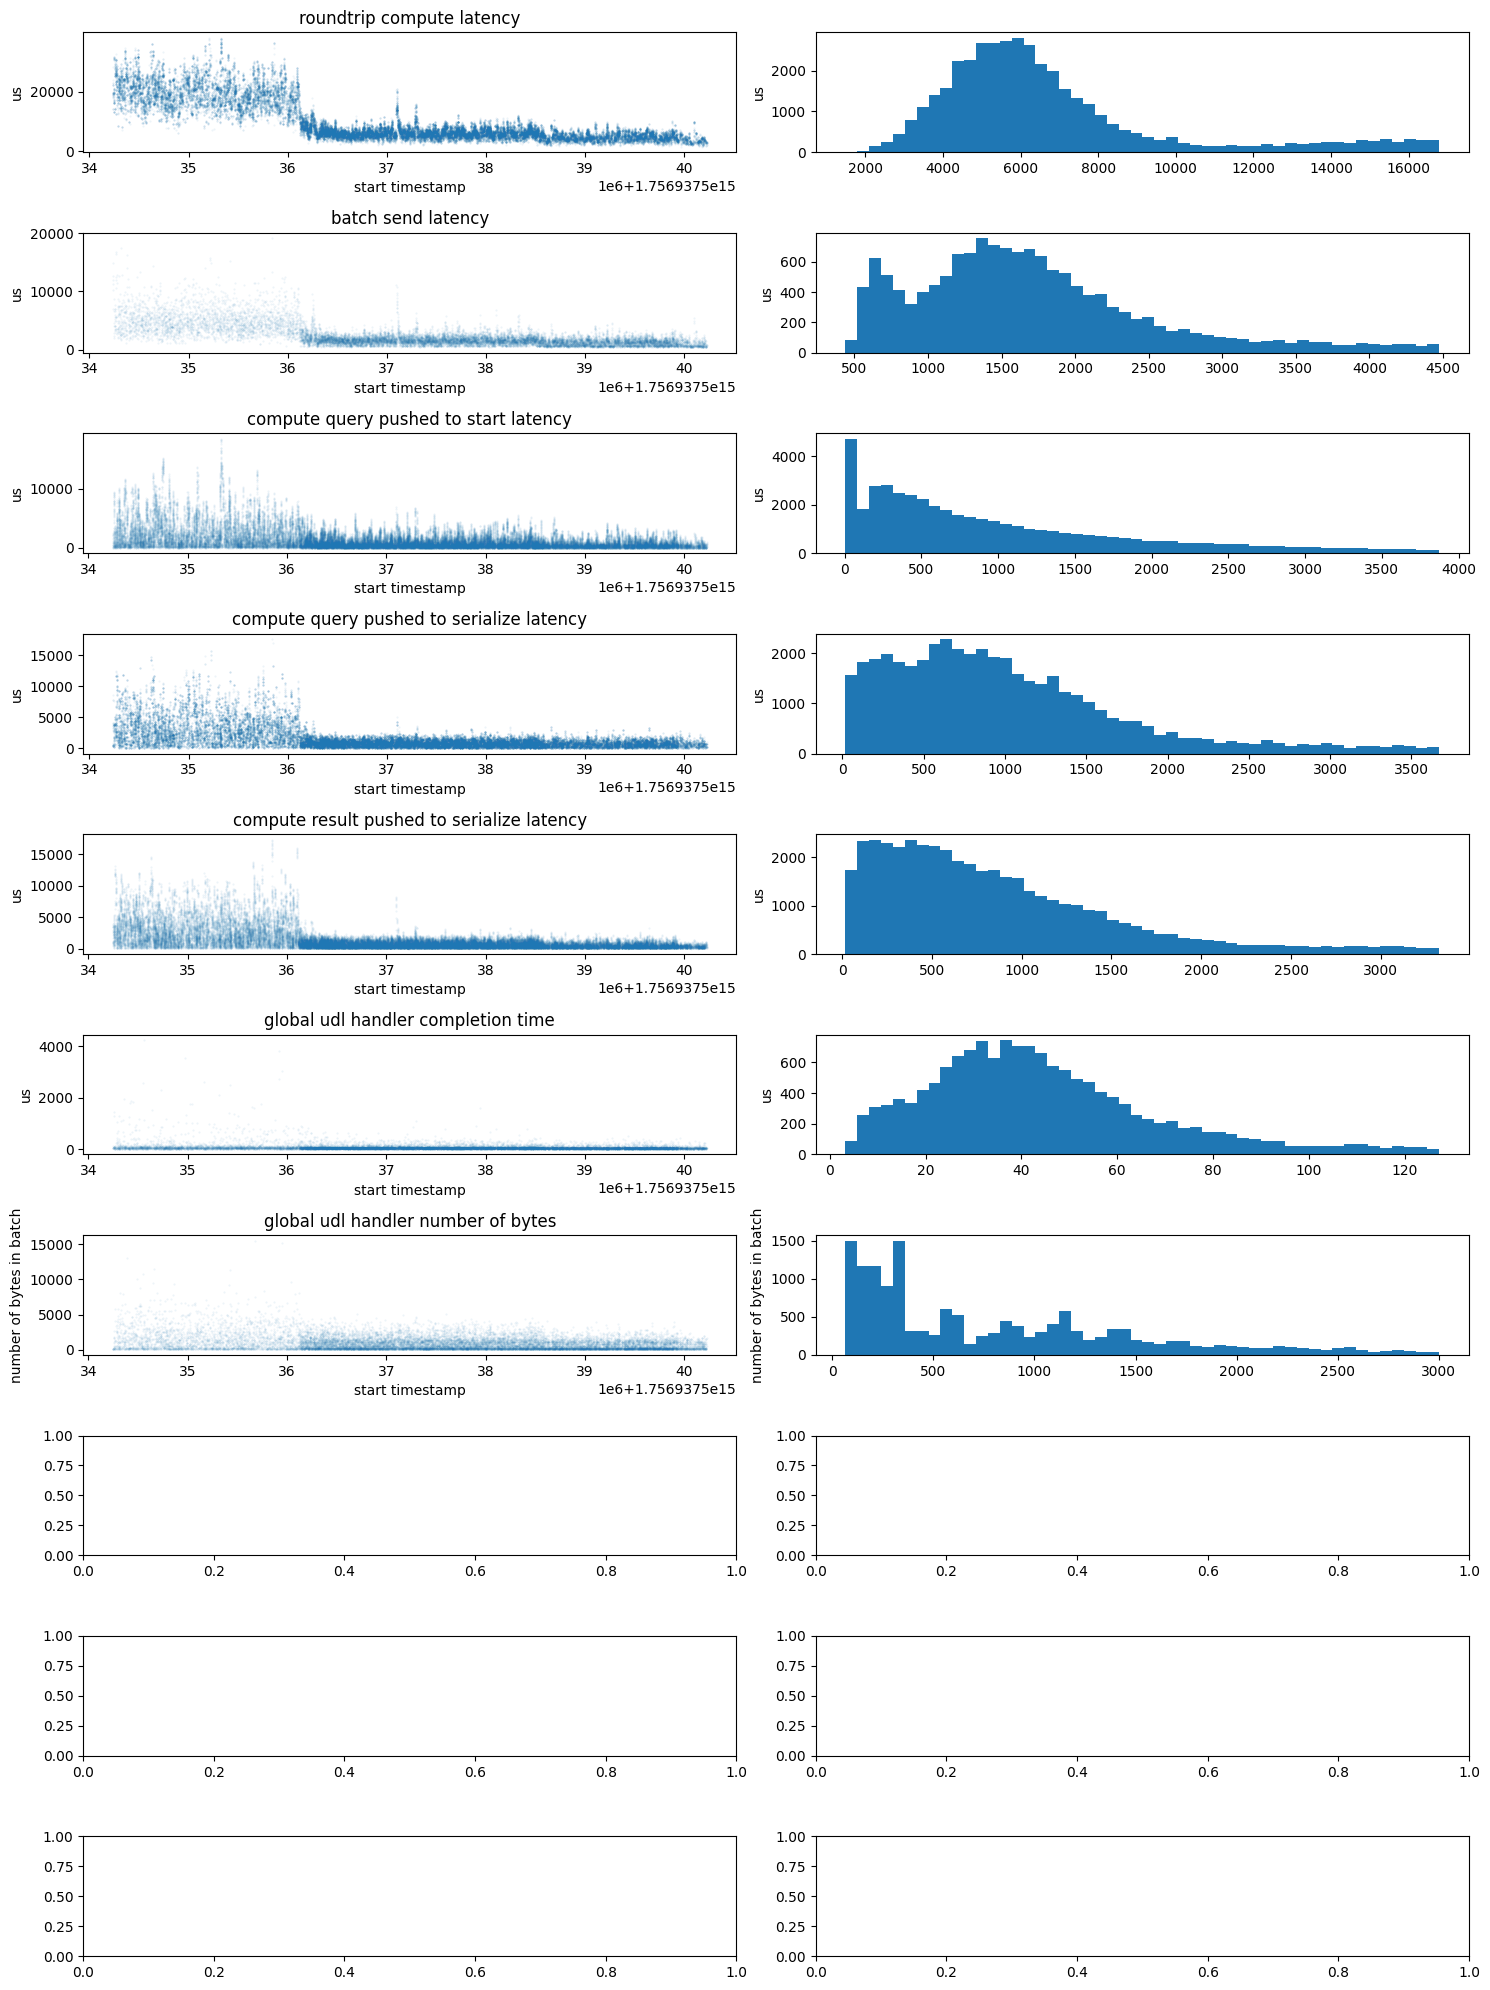

In [53]:
graph_data_from_log_files(local_test_compute_pipeline_data_folder, "grid_test_compute_pipeline.png")

number of existing batch id 453690
No conflicts - all existing batch_ids match the dictionary
round trip latency of compute query
count 50410
mean:  4597.851924221384
std:  3269.2176820316276
90p:   8670.324999999999
99p:  14497.387499999995
compute query duration from send request to start of serialization of that batch on batching thread
count 50410
mean:  711.1439892878398
std:  661.0307767631859
90p:   1181.0
99p:  3480.5
batch serialization time between udls for global search
count 24387
mean:  10.03282486570714
std:  4.2391595610372415
90p:   12.25
99p:  22.5
batch sending latency between udls for global search
num_malformed 1
count 24387
mean:  3236.63354451142
std:  2140.8365414513114
90p:   6055.300000000005
99p:  7921.669999999998
time to complete a put_and_forget
count 24387
mean:  167.39556936072498
std:  430.66113405238264
90p:   207.3000000000011
99p:  2320.994999999999
time to transfer messages from cluster messages to to_send
count 23596
mean:  51.42286828275979
std:  1

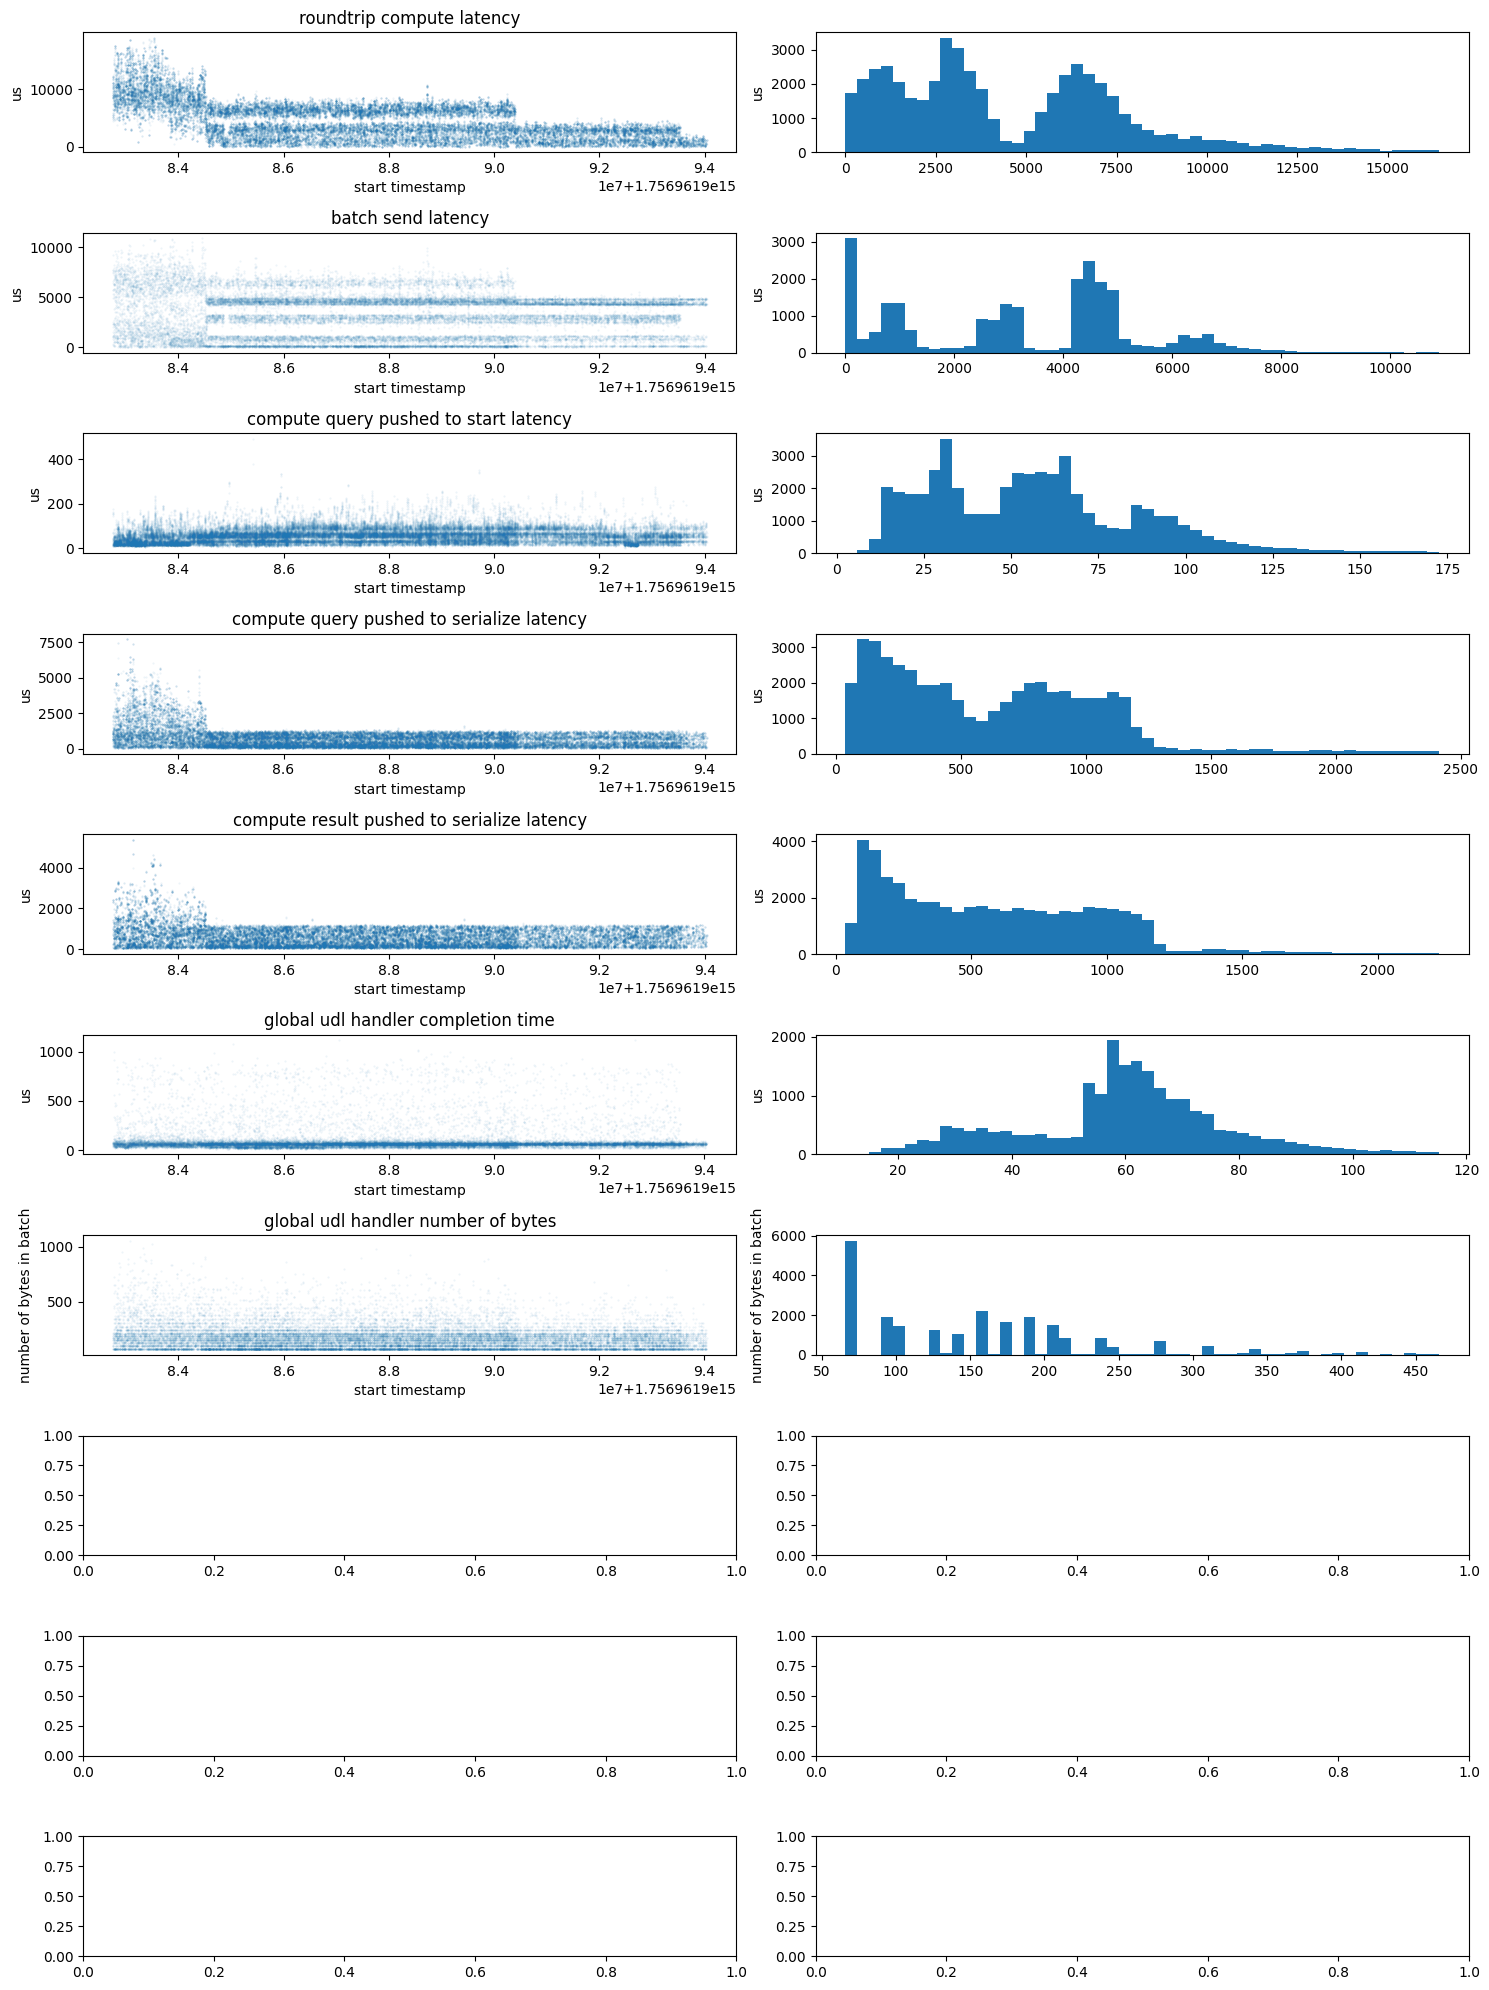

In [54]:
graph_data_from_log_files(remote_rdma_test_compute_pipeline_data_folder, "grid_rdma_test_compute_pipeline.png")

number of existing batch id 861696
No conflicts - all existing batch_ids match the dictionary
round trip latency of compute query
count 50688
mean:  6643.51560033933
std:  7590.658895080128
90p:   10661.575
99p:  31920.629999999866
compute query duration from send request to start of serialization of that batch on batching thread
count 50688
mean:  720.2808357007576
std:  725.1484765939268
90p:   1219.25
99p:  3992.3249999999935
batch serialization time between udls for global search
count 33519
mean:  9.380030728840358
std:  4.012699260768323
90p:   12.25
99p:  22.0
batch sending latency between udls for global search
num_malformed 1
count 33519
mean:  4551.412504847996
std:  2386.286310342398
90p:   7821.75
99p:  10342.66
time to complete a put_and_forget
count 33519
mean:  184.97916853128078
std:  445.53039782233935
90p:   510.3000000000002
99p:  2349.455
time to transfer messages from cluster messages to to_send
count 30920
mean:  47.12593790426908
std:  12.137116893293754
90p:   5

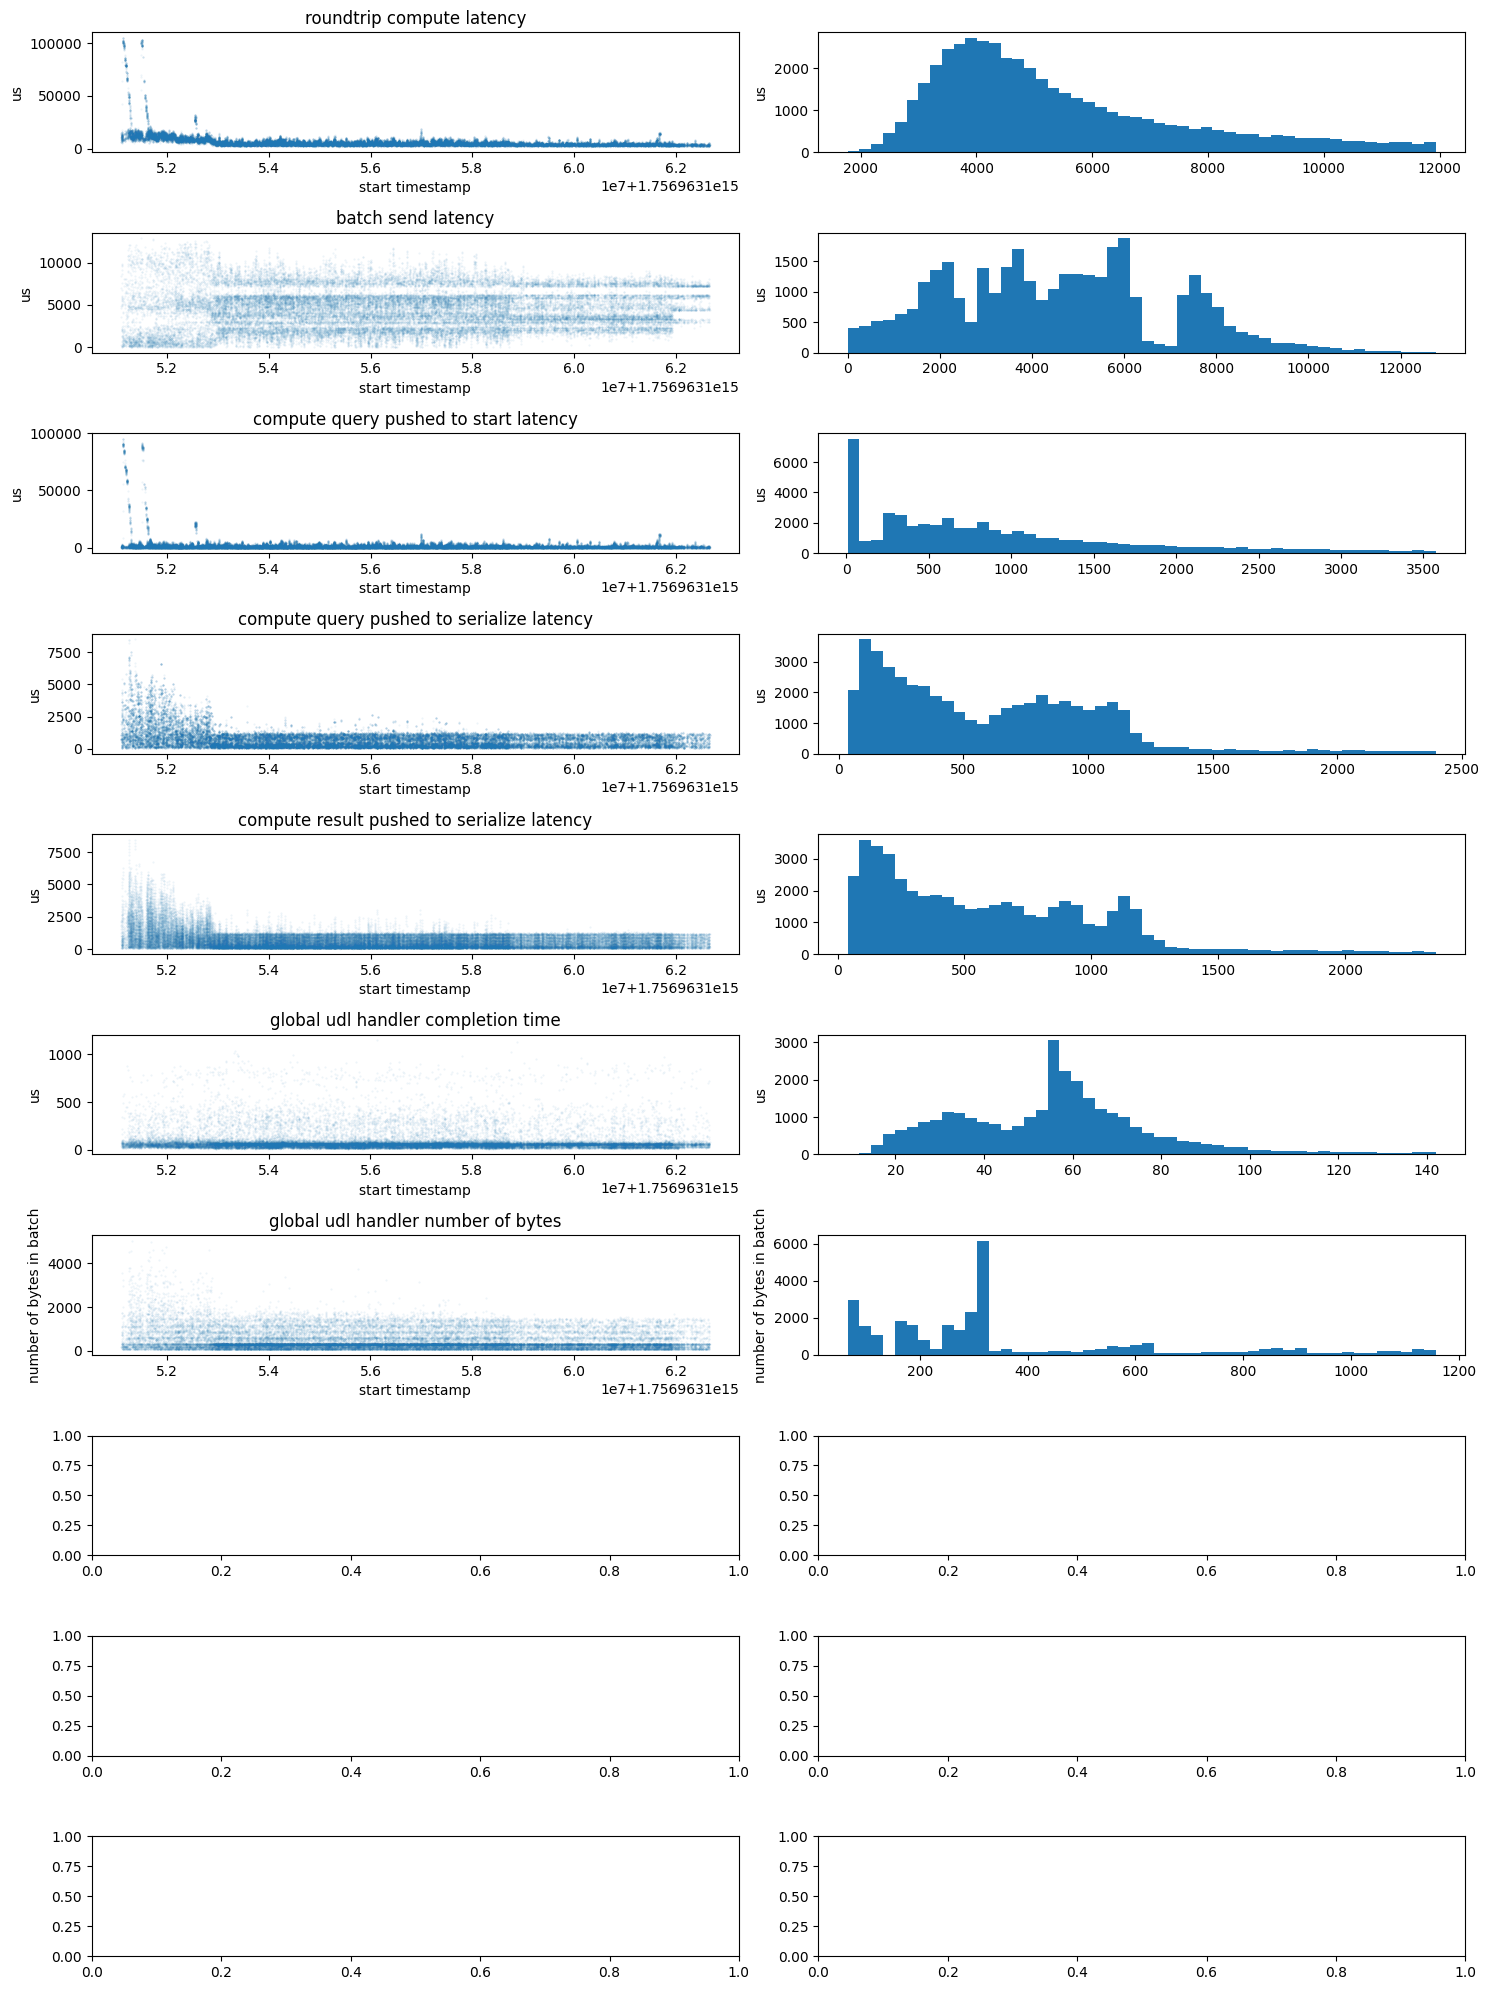

In [55]:
graph_data_from_log_files(remote_rdma_baseline_data_folder, "grid_rdma_baseline.png")